In [1]:
# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# basic libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import glob
from glob import glob

In [2]:
# the path to the image data
RSNA_512_path = '/kaggle/input/rsna-breast-cancer-512-pngs'

In [3]:
# Read the csv data.
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [4]:
# the number of total patients
len(df_train)

54706

In [5]:
# the number of patients having implant
len(df_train[df_train['implant'] == 1])

1477

In [6]:
# the number of patients without malignant cancer
len(df_train[df_train['cancer'] == 0])

53548

In [7]:
# the number of patient who took biopsy
len(df_train[df_train['biopsy'] == 1])

2969

In [8]:
# the number of patients having malignant cancer
len(df_train[df_train['cancer'] == 1])

1158

In [9]:
# the number of patients whose malignant cancer is invasive
len(df_train[df_train['invasive'] == 1])

818

In [10]:
# the same as above
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])

818

<AxesSubplot:xlabel='class', ylabel='count'>

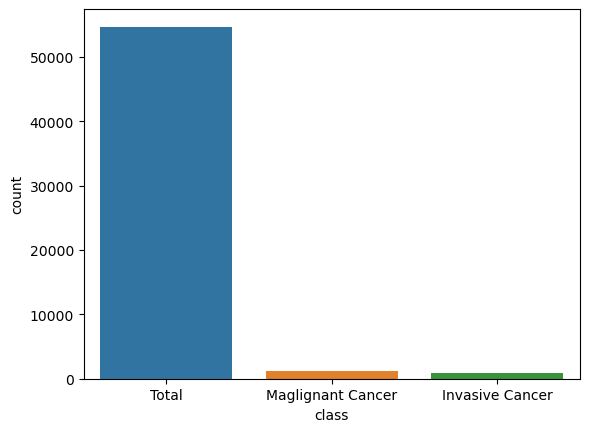

In [11]:
# Most of the cases are normal or not-malignant cancer. Thus, physicians sometimes overlook cancer.
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

<AxesSubplot:xlabel='class', ylabel='count'>

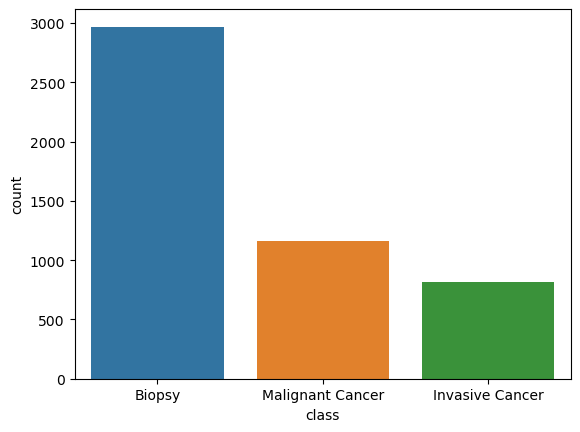

In [12]:
# Around 3000 patient took biopsy and malignant cancer was found from some of them.
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [13]:
# the number of not-malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1811

In [14]:
# the number of malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

1158

<AxesSubplot:xlabel='class', ylabel='count'>

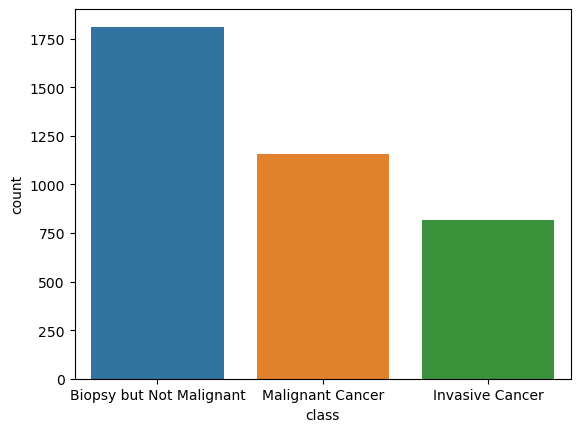

In [15]:
# 60% of biopsy resulted in not-malignanct cancer.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [16]:
# The not-malignant cancer cases were limited into biopsy cases.
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [17]:
# The number of positive (malignant) and negative (not-malignat) cases should be the same
# to create a balanced dataset.
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<AxesSubplot:xlabel='class', ylabel='count'>

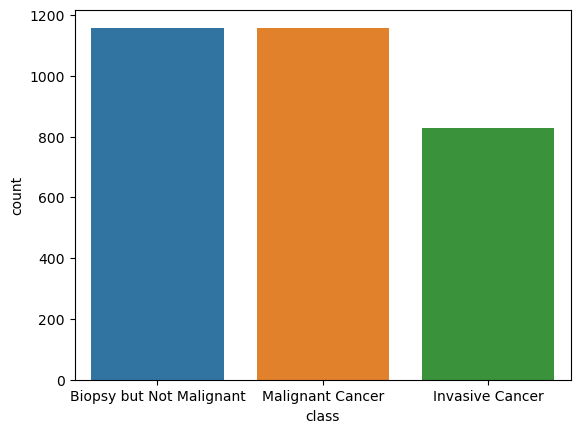

In [18]:
# Generally, invasive cancer is confirmed by biopsy, not by mammography.
# Maybe it is also extremely difficult for AI to detect invasive cancer from mammography.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [19]:
# Create the path to each image.
for i in range(len(DF_train)):
    DF_train.loc[i, 'path'] = os.path.join(RSNA_512_path + '/' + str(DF_train.loc[i, 'patient_id']) + '_' + str(DF_train.loc[i, 'image_id']) + '.png')
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,64252,895397201,R,CC,52.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6425...
1,1,6170,264916414,R,CC,69.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6170...
2,1,58653,1071782369,L,CC,59.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5865...
3,1,24111,1913779264,R,CC,66.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2411...
4,1,27306,1672097872,R,CC,55.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2730...


In [20]:
# a sample path
DF_train.loc[0, 'path']

'/kaggle/input/rsna-breast-cancer-512-pngs/64252_895397201.png'

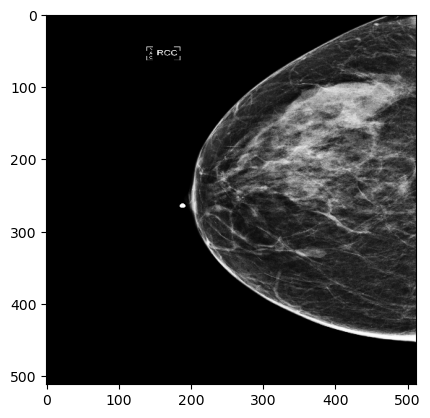

In [21]:
# a sample image
img = cv2.imread(DF_train.loc[0, 'path'])
plt.imshow(img, cmap = 'gray')

In [22]:
img

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 8,  8,  8],
        [ 9,  9,  9],
        [13, 13, 13]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [17, 17, 17],
        [20, 20, 20],
        [18, 18, 18]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [42, 42, 42],
        [67, 67, 67],
        [76, 76, 76]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [23]:
img.shape

(512, 512, 3)

In [24]:
# Normal and cancer images must be equally distrubuted.
train_df, val_df = train_test_split(DF_train, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = DF_train[['cancer']])

print('train', train_df.shape[0], 'validation', val_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('validation', val_df['cancer'].value_counts())
train_df.sample(1)

train 1852 validation 464
train 0    926
1    926
Name: cancer, dtype: int64
validation 0    232
1    232
Name: cancer, dtype: int64


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1672,1,7339,178035245,L,CC,73.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/7339...


In [25]:
# training data
train_df.head(5)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
625,1,30122,704099210,L,CC,70.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3012...
1641,1,59865,835658415,R,MLO,56.0,1,1,1,0.0,0,D,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5986...
313,1,56561,530372146,L,CC,46.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5656...
1726,1,46225,1027379897,L,MLO,63.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4622...
329,1,26644,124965120,R,MLO,52.0,0,1,0,0.0,1,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2664...


In [26]:
# validation data
val_df.head(5)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1072,1,10442,604882069,L,CC,71.0,0,1,0,0.0,0,B,93,True,/kaggle/input/rsna-breast-cancer-512-pngs/1044...
777,1,23784,23178505,R,CC,47.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2378...
394,1,9039,1862782313,L,CC,61.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/9039...
356,1,31130,111821056,R,CC,54.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3113...
1818,2,48939,698067885,R,MLO,62.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/4893...


In [27]:
# Pick up normal images from the training data.
train_df_normal = train_df[train_df['cancer'] == 0].reset_index(drop = True)
print(len(train_df_normal))
train_df_normal.head(5)

926


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,30122,704099210,L,CC,70.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3012...
1,1,56561,530372146,L,CC,46.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5656...
2,1,26644,124965120,R,MLO,52.0,0,1,0,0.0,1,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2664...
3,1,11095,297882448,R,CC,49.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1109...
4,1,22223,1038633621,L,MLO,80.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2222...


In [28]:
# Pick up cancer images from the training data.
train_df_cancer = train_df[train_df['cancer'] == 1].reset_index(drop = True)
print(len(train_df_cancer))
train_df_cancer.head(5)

926


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,59865,835658415,R,MLO,56.0,1,1,1,0.0,0,D,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5986...
1,1,46225,1027379897,L,MLO,63.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4622...
2,1,21923,138972646,R,MLO,64.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2192...
3,2,40511,732225940,L,MLO,68.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/4051...
4,1,18026,1943507092,R,MLO,67.0,1,1,1,0.0,1,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1802...


In [29]:
# Pick up normal images from the validation data.
val_df_normal = val_df[val_df['cancer'] == 0].reset_index(drop = True)
print(len(val_df_normal))
val_df_normal.head(5)

232


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,10442,604882069,L,CC,71.0,0,1,0,0.0,0,B,93,True,/kaggle/input/rsna-breast-cancer-512-pngs/1044...
1,1,23784,23178505,R,CC,47.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2378...
2,1,9039,1862782313,L,CC,61.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/9039...
3,1,31130,111821056,R,CC,54.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3113...
4,1,63208,1359883512,L,CC,51.0,0,1,0,0.0,0,D,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6320...


In [30]:
# Pick up cancer images from the validation data.
val_df_cancer = val_df[val_df['cancer'] == 1].reset_index(drop = True)
print(len(val_df_cancer))
val_df_cancer.head(5)

232


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,48939,698067885,R,MLO,62.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/4893...
1,1,60519,1303753411,L,MLO,50.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/6051...
2,1,39723,2055158152,R,MLO,58.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3972...
3,1,21067,715321439,R,CC,47.0,1,1,0,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2106...
4,1,11094,1882170663,L,CC,74.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1109...


In [31]:
import shutil
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [32]:
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [33]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [34]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

# Sample Images

In [35]:
import glob
normal_train_images = glob.glob('/kaggle/working/train/normal/*.png')
cancer_train_images = glob.glob('/kaggle/working/train/cancer/*.png')

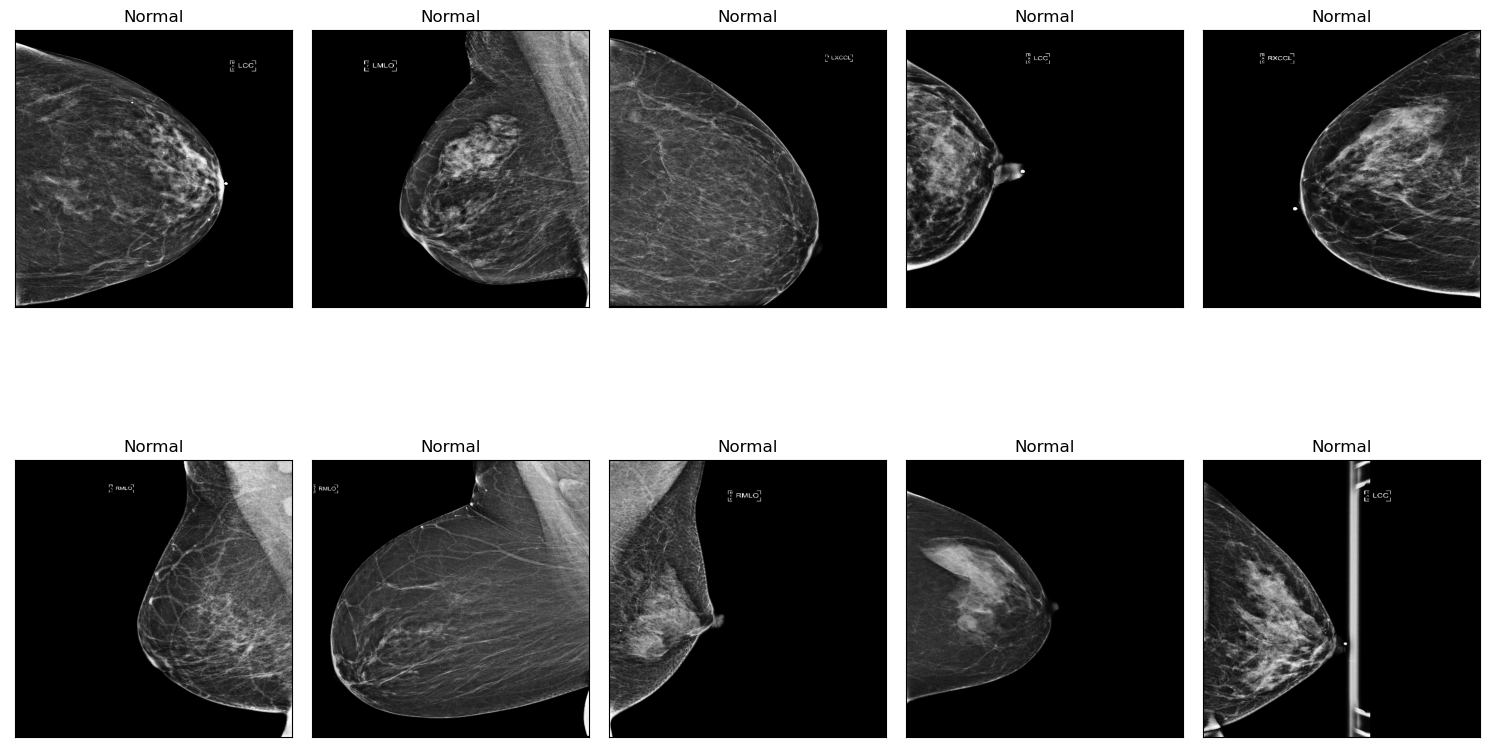

In [36]:
# See normal images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
fig.tight_layout()    

plt.show()

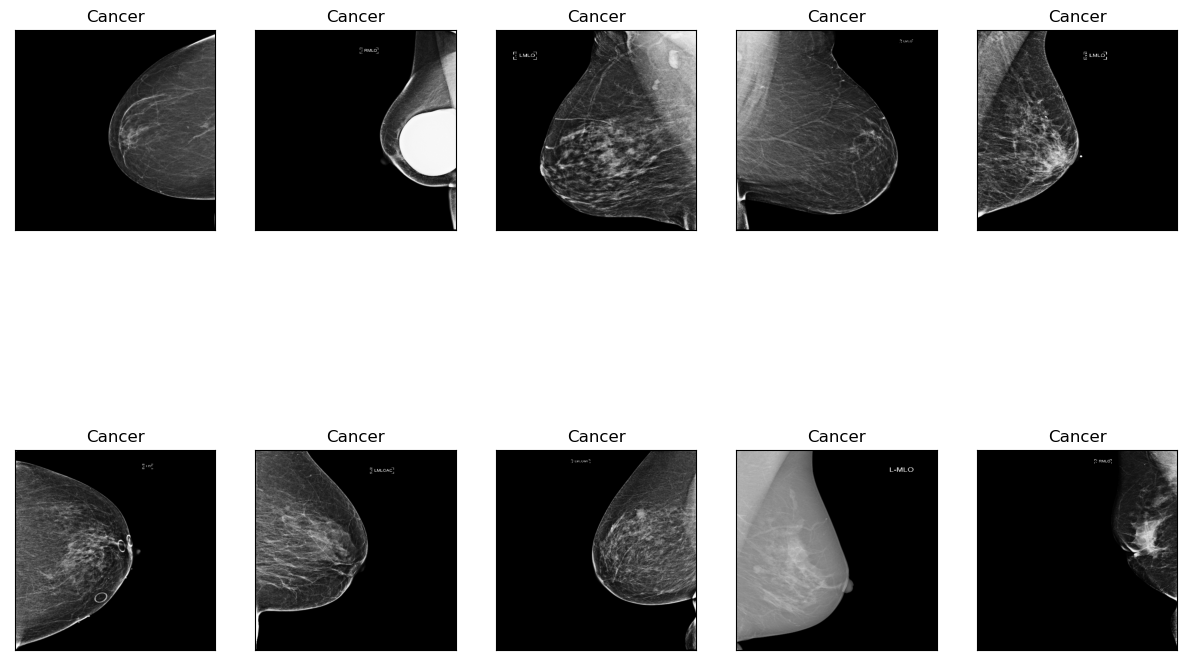

In [37]:
# See cancer images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cancer_train_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')
    
plt.show()

In [38]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [39]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (512, 512),
        batch_size = 16,
        class_mode = 'binary'
)

Found 1354 images belonging to 2 classes.
Found 426 images belonging to 2 classes.


In [40]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

94668760/94668760 [==============================] - 4s 0us/step


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
______________________________________

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 53s 2s/step - loss: 0.7021 - accuracy: 0.5594 - val_loss: 0.6498 - val_accuracy: 0.6362
Epoch 2/15
20/20 [==============================] - 41s 2s/step - loss: 0.6635 - accuracy: 0.6117 - val_loss: 0.6376 - val_accuracy: 0.5986
Epoch 3/15
20/20 [==============================] - 41s 2s/step - loss: 0.6684 - accuracy: 0.5825 - val_loss: 0.6252 - val_accuracy: 0.6573
Epoch 4/15
20/20 [==============================] - 40s 2s/step - loss: 0.6493 - accuracy: 0.6197 - val_loss: 0.6338 - val_accuracy: 0.5986
Epoch 5/15
20/20 [==============================] - 41s 2s/step - loss: 0.6159 - accuracy: 0.6562 - val_loss: 0.6247 - val_accuracy: 0.6549
Epoch 6/15
20/20 [==============================] - 41s 2s/step - loss: 0.6344 - accuracy: 0.6262 - val_loss: 0.6610 - val_accuracy: 0.6244
Epoch 7/15
20/20 [==============================] - 40s 2s/step - loss: 0.6175 - accuracy: 0.6683 - val_loss: 0.6185 - val_accuracy: 0.6197
Epoch 8/15
20/20 [==

# Save the Model

In [43]:
model.save('mammography_pred_model.h5')

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

Text(0, 0.5, 'loss')

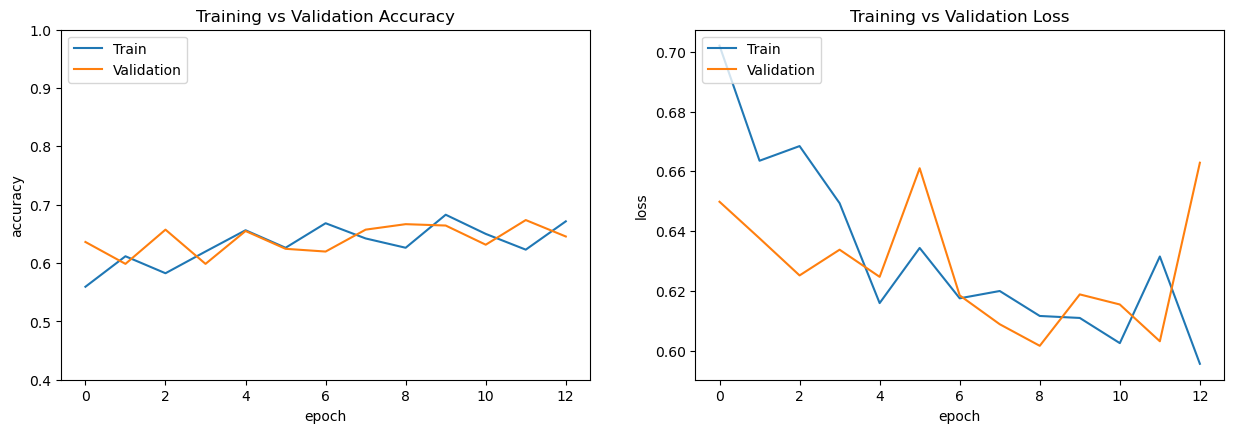

In [45]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

In [46]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/mammography_pred_model.h5')

In [47]:
pred = model.predict(validation_generator)

27/27 [==============================] - 6s 174ms/step


In [48]:
# prediction by the AI
pred

array([[0.8277852 ],
       [0.7561805 ],
       [0.7055073 ],
       [0.82541186],
       [0.80813575],
       [0.12321641],
       [0.49323702],
       [0.7966075 ],
       [0.49090463],
       [0.8650601 ],
       [0.6968941 ],
       [0.46281883],
       [0.6218187 ],
       [0.75252104],
       [0.7357672 ],
       [0.57974803],
       [0.87604225],
       [0.92309195],
       [0.61053884],
       [0.581413  ],
       [0.678206  ],
       [0.67029256],
       [0.79371184],
       [0.72280014],
       [0.7373695 ],
       [0.7532023 ],
       [0.11844703],
       [0.5697386 ],
       [0.6519257 ],
       [0.13225165],
       [0.4709853 ],
       [0.65038526],
       [0.5758412 ],
       [0.81079537],
       [0.7735053 ],
       [0.6662132 ],
       [0.9126051 ],
       [0.7126791 ],
       [0.72360617],
       [0.64920443],
       [0.7192445 ],
       [0.28764337],
       [0.8071758 ],
       [0.35153678],
       [0.767447  ],
       [0.88782346],
       [0.73610556],
       [0.707

In [49]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [50]:
print(y_pred)

[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 

In [51]:
pd.Series(y_pred).value_counts()

1    349
0     77
dtype: int64

In [52]:
y_true = validation_generator.classes

In [53]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [54]:
cm = confusion_matrix(y_true, y_pred)

Text(50.722222222222214, 0.5, 'Truth')

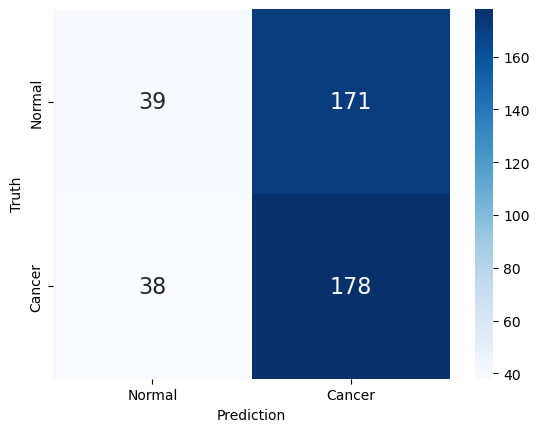

In [55]:
# Define the class names.
class_names = ['Normal', 'Cancer']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

In [56]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.19      0.27       210
           1       0.51      0.82      0.63       216

    accuracy                           0.51       426
   macro avg       0.51      0.50      0.45       426
weighted avg       0.51      0.51      0.45       426



In [57]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [58]:
print(confusion)

['FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP

In [59]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,FP
1,FP
2,FP
3,FP
4,FP
...,...
421,FN
422,TP
423,TP
424,TP


In [60]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,1,0,FP
1,1,0,FP
2,1,0,FP
3,1,0,FP
4,1,0,FP
...,...,...,...
421,0,1,FN
422,1,1,TP
423,1,1,TP
424,1,1,TP


In [61]:
confusion_table.Results == 'FP'

0       True
1       True
2       True
3       True
4       True
       ...  
421    False
422    False
423    False
424    False
425    False
Name: Results, Length: 426, dtype: bool

In [62]:
# list of false positive images
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
0,1,0,FP
1,1,0,FP
2,1,0,FP
3,1,0,FP
4,1,0,FP
...,...,...,...
205,1,0,FP
206,1,0,FP
207,1,0,FP
208,1,0,FP


In [63]:
FPs.index

Int64Index([  0,   1,   2,   3,   4,   7,   9,  10,  12,  13,
            ...
            198, 199, 202, 203, 204, 205, 206, 207, 208, 209],
           dtype='int64', length=171)

In [64]:
# list of false negative images
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
233,0,1,FN
240,0,1,FN
244,0,1,FN
245,0,1,FN
258,0,1,FN
268,0,1,FN
272,0,1,FN
275,0,1,FN
279,0,1,FN
281,0,1,FN


In [65]:
FNs.index

Int64Index([233, 240, 244, 245, 258, 268, 272, 275, 279, 281, 285, 287, 290,
            294, 304, 307, 317, 319, 321, 326, 328, 334, 337, 339, 347, 351,
            353, 357, 365, 371, 374, 393, 394, 404, 409, 410, 418, 421],
           dtype='int64')

In [66]:
import glob
val_images = glob.glob('/kaggle/working/val/*/*.png')

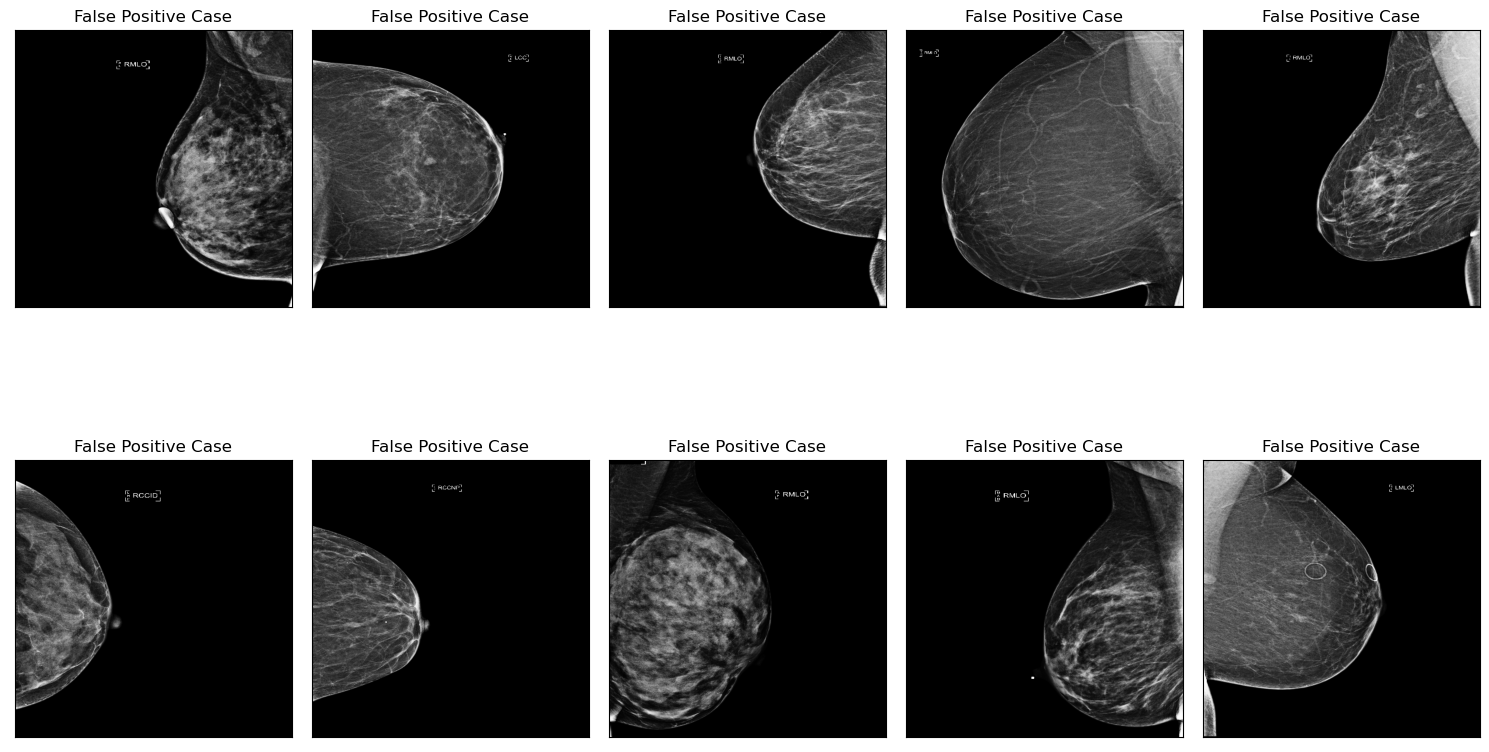

In [67]:
# False positive imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

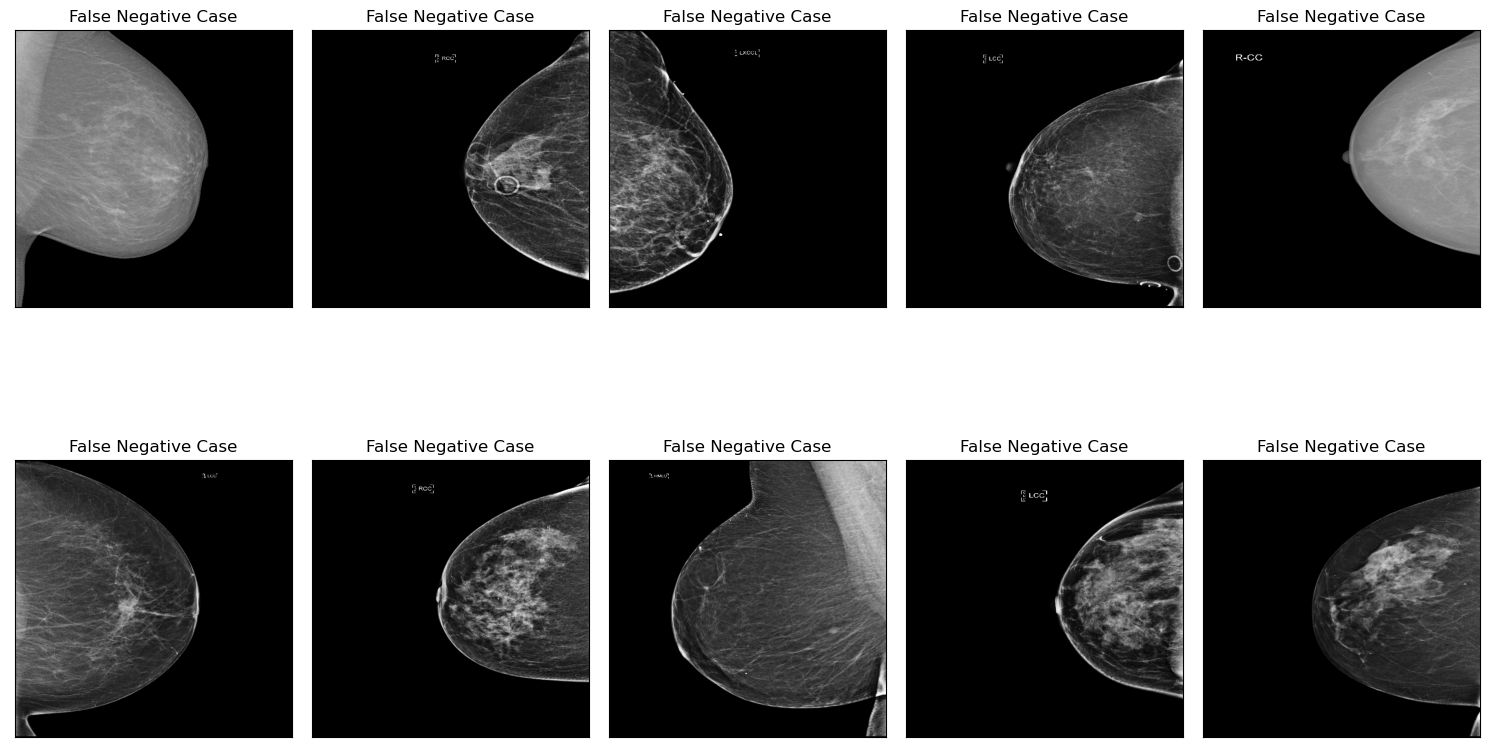

In [68]:
# False negative imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FNs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Negative Case")
fig.tight_layout()    

plt.show()

In [69]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non-trainable params: 45,440
_____________________________________

In [71]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 50, callbacks = callback)

Epoch 1/50
20/20 [==============================] - 75s 2s/step - loss: 0.6957 - accuracy: 0.5500 - val_loss: 784.3458 - val_accuracy: 0.4930
Epoch 2/50
20/20 [==============================] - 44s 2s/step - loss: 0.6654 - accuracy: 0.6016 - val_loss: 811.3091 - val_accuracy: 0.5070
Epoch 3/50
20/20 [==============================] - 44s 2s/step - loss: 0.6540 - accuracy: 0.6084 - val_loss: 1181.7946 - val_accuracy: 0.4930
Epoch 4/50
20/20 [==============================] - 45s 2s/step - loss: 0.6821 - accuracy: 0.6000 - val_loss: 14041.3262 - val_accuracy: 0.4930
Epoch 5/50
20/20 [==============================] - 46s 2s/step - loss: 0.6631 - accuracy: 0.5906 - val_loss: 28.5741 - val_accuracy: 0.4930
Epoch 6/50
20/20 [==============================] - 45s 2s/step - loss: 0.6454 - accuracy: 0.5891 - val_loss: 1.3704 - val_accuracy: 0.5376
Epoch 7/50
20/20 [==============================] - 46s 2s/step - loss: 0.6680 - accuracy: 0.6172 - val_loss: 1.1898 - val_accuracy: 0.6056
Epoch 8/

In [72]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [73]:
final_accuracy

0.5399060845375061

# Model Metrics

In [74]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

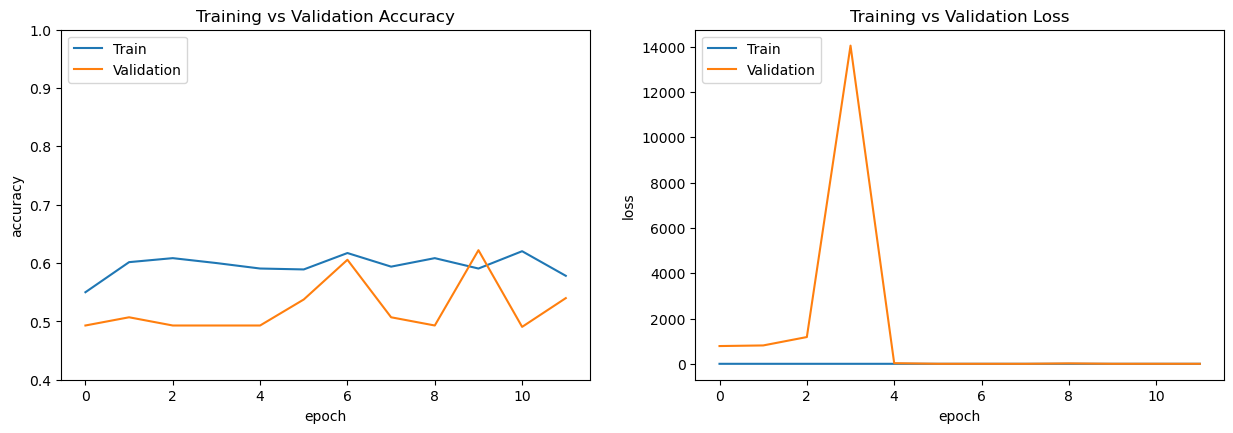

In [75]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# Save the Model

In [76]:
model.save('mammography_pred_model_finetuning.h5')

In [77]:
#VGG16

from keras.applications.vgg16 import VGG16


 #FineTuning
base_model = VGG16(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

58889256/58889256 [==============================] - 2s 0us/step


In [78]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x787b01301290>>

In [79]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 10, epochs = 30, callbacks = callback)

Epoch 1/30
10/10 [==============================] - 55s 4s/step - loss: 1.2494 - accuracy: 0.5375 - val_loss: 0.6984 - val_accuracy: 0.5070
Epoch 2/30
10/10 [==============================] - 28s 3s/step - loss: 0.7166 - accuracy: 0.5094 - val_loss: 0.6907 - val_accuracy: 0.5070
Epoch 3/30
10/10 [==============================] - 27s 3s/step - loss: 0.7318 - accuracy: 0.4195 - val_loss: 0.6944 - val_accuracy: 0.4930
Epoch 4/30
10/10 [==============================] - 26s 3s/step - loss: 0.6991 - accuracy: 0.5336 - val_loss: 0.6975 - val_accuracy: 0.4930
Epoch 5/30
10/10 [==============================] - 26s 3s/step - loss: 0.7002 - accuracy: 0.5034 - val_loss: 0.6926 - val_accuracy: 0.4930
Epoch 6/30
10/10 [==============================] - 27s 3s/step - loss: 0.6979 - accuracy: 0.5031 - val_loss: 0.7025 - val_accuracy: 0.5070


In [80]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [81]:
final_accuracy

0.5070422291755676

In [82]:
#VGG19
from tensorflow.keras.applications.vgg19 import VGG19
base_model = VGG19(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

80134624/80134624 [==============================] - 3s 0us/step


In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,090,177
Trainable params: 20,090,177
Non-trainable params: 0
__________________________________________

In [84]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 10, epochs = 30, callbacks = callback)

Epoch 1/30
10/10 [==============================] - 33s 3s/step - loss: 222.5732 - accuracy: 0.5344 - val_loss: 0.7109 - val_accuracy: 0.5070
Epoch 2/30
10/10 [==============================] - 28s 3s/step - loss: 0.7169 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.5070
Epoch 3/30
10/10 [==============================] - 28s 3s/step - loss: 0.7269 - accuracy: 0.4875 - val_loss: 0.6941 - val_accuracy: 0.4930
Epoch 4/30
10/10 [==============================] - 28s 3s/step - loss: 0.7252 - accuracy: 0.5031 - val_loss: 0.6979 - val_accuracy: 0.4930
Epoch 5/30
10/10 [==============================] - 28s 3s/step - loss: 0.7022 - accuracy: 0.4938 - val_loss: 0.7464 - val_accuracy: 0.4930
Epoch 6/30
10/10 [==============================] - 28s 3s/step - loss: 0.7043 - accuracy: 0.5063 - val_loss: 0.7049 - val_accuracy: 0.5070


In [85]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [86]:
final_accuracy

0.5070422291755676